In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import emcee
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
cd '/Users/virgi/Desktop/ET/COVID-19/dati-regioni'

/Users/virgi/Desktop/ET/COVID-19/dati-regioni


In [4]:
file=os.listdir('.') 
file=sorted(file) #ordinali !!

print(f'# files: {len(file)}')
print(f'primo: {file[0]}')
print(file[1060])
print(file[1061])
print(f'ultimo: {file[1062]}') #ultimo file ha tutto

# files: 1064
primo: dpc-covid19-ita-regioni-20200224.csv
dpc-covid19-ita-regioni-20230119.csv
dpc-covid19-ita-regioni-latest.csv
ultimo: dpc-covid19-ita-regioni.csv


In [5]:
FVG=pd.read_csv('dpc-covid19-ita-regioni.csv')

nuovi_positivi_FVG=FVG[FVG['codice_regione']==6]['nuovi_positivi']
nuovi_positivi_FVG=np.array(nuovi_positivi_FVG) #array

for i in range(len(nuovi_positivi_FVG)):
    if nuovi_positivi_FVG[i]<0.0 or nuovi_positivi_FVG[i]==np.nan:
        nuovi_positivi_FVG[i]=0.0

#verifica che hai tutti i file
dates=pd.date_range(start="2020-02-24",end="2023-01-19")
print(len(dates)) 
print(len(nuovi_positivi_FVG))

1061
1061


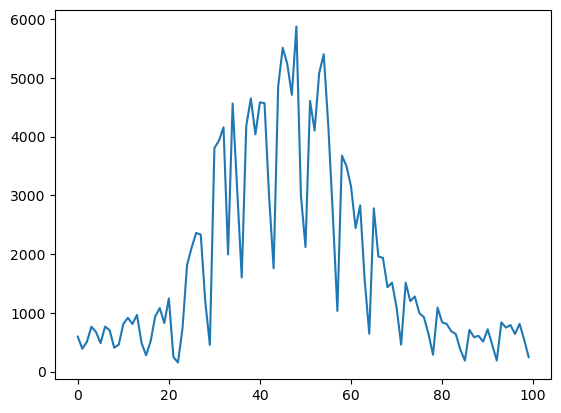

In [6]:
plt.plot(nuovi_positivi_FVG[650:750]) # 650:750  #70:367

In [7]:
from scipy.stats import gompertz, poisson

In [8]:
NP_FVG=nuovi_positivi_FVG[650:750]
NP_FVG_cum=np.cumsum(NP_FVG)

In [9]:
L=len(NP_FVG)

In [10]:
def Gompertz(t, theta1, theta2, theta3):
    '''
    theta1: The asymptote.
    theta2: The displacement along the x-axis.
    theta3: The growth rate.
    '''
    f = theta1 * np.exp(-theta2 * np.exp(-theta3 * t))
    return f

In [12]:
country = 'Friuli Venezia Giulia '
x_train = np.arange(L)
confirmed_train = NP_FVG_cum
x_test = x_train

In [13]:
popt_confirmed, pcov_confirmed = curve_fit(f = Gompertz, 
                                           xdata = x_train, 
                                           ydata = confirmed_train, 
                                           p0 = [3 * max(confirmed_train), 1, 1], 
                                           maxfev = 800)

In [14]:
popt_confirmed # optimal parameters

array([1.89355520e+05, 1.07938281e+01, 5.96398632e-02])

In [15]:
pcov_confirmed # covariance matrix of the parameter estimates

array([[ 1.69831740e+06, -4.47915397e+02, -1.31911393e+00],
       [-4.47915397e+02,  2.53784302e-01,  6.08246322e-04],
       [-1.31911393e+00,  6.08246322e-04,  1.56877251e-06]])

In [16]:
def curve_plot(x_train, y_train, x_test, est):
    plt.figure(figsize = (12, 5))
    plt.xlabel('Days')
    plt.ylabel('Cases')
    plt.title(country)
    plt.scatter(x_train, y_train, color = 'r', label='data')
    plt.plot(x_train, Gompertz(x_train, *est), label = 'Fitting curve')
    plt.legend()
    plt.show()

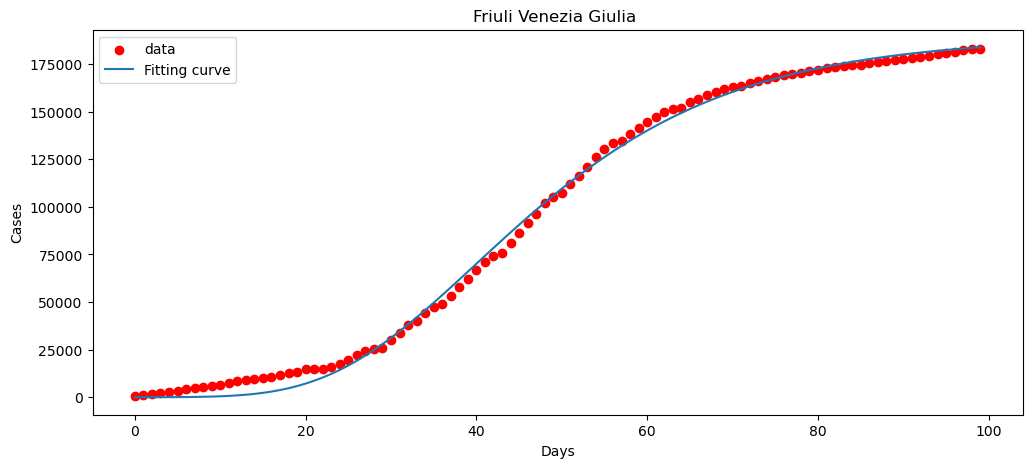

In [17]:
curve_plot(x_train = x_train, y_train = confirmed_train, x_test = x_test, est = popt_confirmed)

In [18]:
y = NP_FVG_cum
x = np.arange(len(y))
y_mean = np.mean(NP_FVG)

popt, pcov = curve_fit(Gompertz, x, y, p0 = [3 * max(confirmed_train), 1, 1], maxfev = 800)

popt

array([1.89355520e+05, 1.07938281e+01, 5.96398632e-02])

In [20]:
# Load data for new cases
y = NP_FVG_cum
x = np.arange(len(y))
#y = data


# Define the Gompertz function
def gompertz(x, params):
    a, b, c = params
    return a * np.exp(-b * np.exp(-c * x))


# Define the prior distributions for the parameters
#def log_prior(params):
#    a, b, c = params
#    if 185000 < a < 195000 and 5 < b < 15 and -0.2 < c < 0.2: # a tra 170 e 190 e b tra o e 50
#        return 0.0
#    return -np.inf


# Define the likelihood function
#def log_likelihood(params, y, y_mean): # anche x tra gli argomenti?
#    a, b, c = params
#    y_mean = np.mean(y)
#    y_pred = gompertz(x, params) 
    #return np.sum(y * np.log(y_pred) - y_pred - np.log(factorial(y)))
    #return np.sum(y_mean * np.log(y_pred) - y_pred) #- np.log(factorial(y_mean)))
#    return np.sum(y*np.log(y_pred) - y_pred)
    
#Define the full probability function
#def log_probability(params, x, y): 
#    lp = log_prior(params)
#    if not np.isfinite(lp):
#        return -np.inf
    #return lp + log_likelihood(params, x, y)
#    return lp + log_likelihood(params, y, y_mean) # x?


#def log_posterior(params, x, y):
#    lp = log_prior(params)
#    if not np.isfinite(lp):
#        return -np.inf
#    logl = log_likelihood(params, y, y_mean) # x?
#    logpos = logl+lp
#    if not np.isfinite(logpos):
#        return -np.inf
#    return logpos

########################

def log_prior(params):
    a, b, c = params
    if 185000 < a < 195000 and 5 < b < 15 and -0.07 < c < 0.07: # a tra 170 e 190 e b tra o e 50
        return 0.0
    return -np.inf


# Define the likelihood function
def log_likelihood(params, x, y):
    a, b, c = params
    #y_mean = np.mean(y)
    y_pred = gompertz(x, params) 
    return np.sum(y * np.log(y_pred) - y_pred) 
    
#Define the full probability function
def log_probability(params, x, y): 
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y)


def log_posterior(params, x, y):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    logl = log_likelihood(params, x, y) 
    logpos = logl+lp
    if not np.isfinite(logpos):
        return -np.inf
    return logpos

In [21]:
pos =  popt + 1e-4 * np.random.randn(16, 3) #soln.x + 1e-4...

pos2 = np.zeros((16,3))


#popt0 = popt[0] + 10 * np.random.randn(32)
#popt1 = popt[1] + 1e-4 * np.random.randn(32)
#popt2 = popt[2] + 1e-4 * np.random.randn(32)

#for i in range(32):
    
#    pos2[i] = np.array([popt0[i], popt1[i], popt2[i]])

ndim, nwalkers = 3, 16

#pos2


100%|███████████████████████████████████| 10000/10000 [00:04<00:00, 2142.76it/s]


(10000, 16, 3)


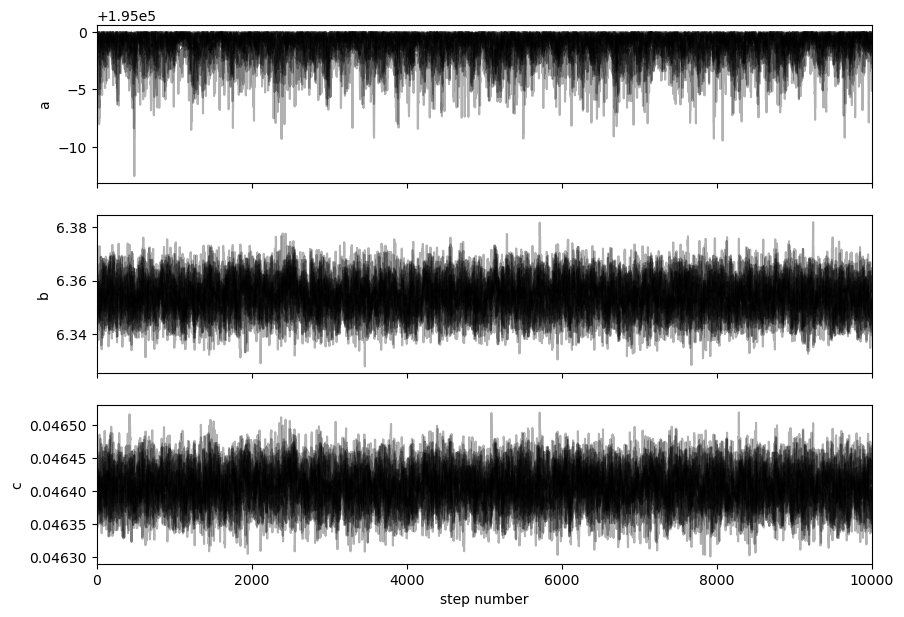

In [23]:
# Initialize the walkers
#nwalkers, ndim = pos.shape # 3 è il mio numero di parametri

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y))  #log_probability funziona meglio

# Run the MCMC
pos, prob, state = sampler.run_mcmc(pos, 10000, progress=True)


fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(samples.shape)
labels = ["a", "b", "c"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [24]:
tau = sampler.get_autocorr_time()
print(tau)

[60.23510272 49.66865938 50.98137668]


In [25]:
flat_samples = sampler.get_chain(discard=100, flat=True)
print(samples.shape)
flat_blob = sampler.get_blobs(flat=True, discard=100)
print(flat_blob)

(10000, 16, 3)
None


In [26]:
#Max_likelihood=np.argmax(flat_blob[:,1])

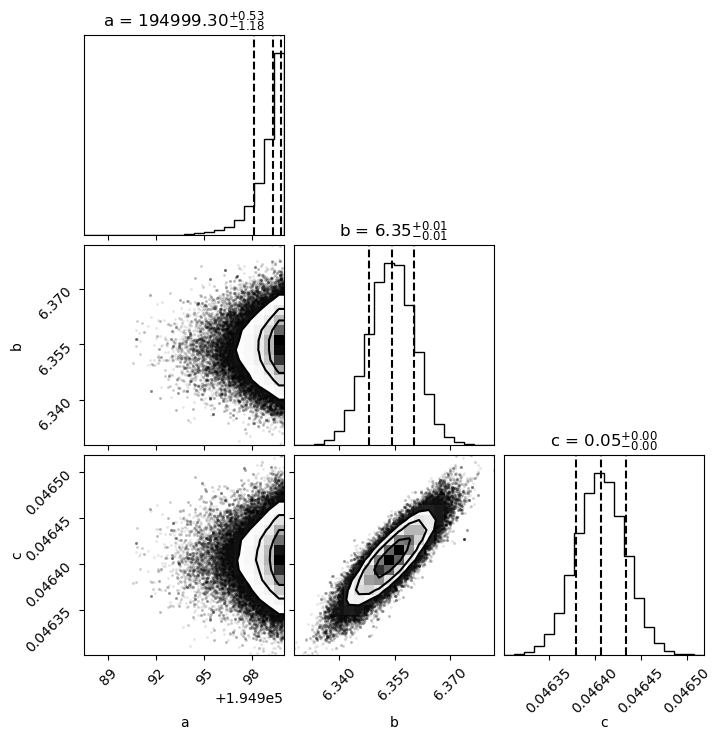

In [27]:
import corner
labels = ['a', 'b', 'c']
fig = corner.corner(flat_samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])